In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
def histogram_residuals(mu_ss, mu_gp, var_ss, var_gp):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), sharey=True)
    ax1.hist(mu_ss-mu_gp)
    ax2.hist(var_ss-var_gp)
    ax1.set(xlabel=r'$\mu_{ss} - \mu_{gp}$', )
    ax2.set(xlabel=r'$\sigma^2_{ss} - \sigma^2_{gp}$');
    fig.tight_layout()
    return fig, (ax1, ax2)

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

# Kernel definition

In [13]:
import tinygp
import smolgp

In [ ]:
# ## SHO Kernel
# S=2.36
# w=0.0195
# Q=7.63
# sigma = jnp.sqrt(S*w*Q)

# qsKernel = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
# ssKernel = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
# gpKernel = testgp.SHOKernel(w=w, Q=Q, S=S)

# ikernel = smolgp.kernels.integrated.IntegratedSHO(omega=w, quality=Q, sigma=sigma, num_insts=1)

In [26]:
## Matern-5/2 Kernel
scale = 300
sigma = 3.2

qsKernel = tinygp.kernels.quasisep.Matern52(scale=scale, sigma=sigma)
ssKernel = smolgp.kernels.Matern52(scale=scale, sigma=sigma)

ikernel = smolgp.kernels.integrated.IntegratedMatern52(scale=scale, sigma=sigma, num_insts=1)

In [27]:
true_kernel = qsKernel

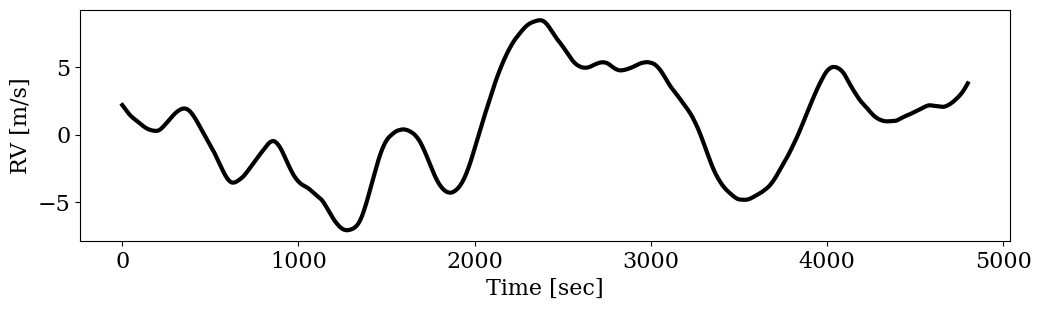

In [28]:
def get_true_gp(tmin, tmax, tunit='s', dt=1):
    t = u.Quantity(jnp.arange(tmin, tmax, dt), tunit).to('s').value
    true_gp = tinygp.GaussianProcess(true_kernel, t)
    # gp.sample adds small random noise for numerical stability
    y_sample = true_gp.sample(key=jax.random.PRNGKey(32)) 
    f = make_smoothing_spline(t, y_sample, lam=10/60)
    return t, f

baseline_minutes = 80
t, f = get_true_gp(0, baseline_minutes, 'min', dt=1/60)
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(t, f(t), label='Example SHO', color='k', lw=3)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

## Make synthetic observations

In [29]:
#### Simulated dataset
def generate_data(N, yerr=0.3, tmin=None, tmax=None, baseline_minutes=80):

    # Generate true GP over baseline
    t, f = get_true_gp(0, baseline_minutes, 'min', dt=1/60)
    tmin = t.min() if tmin is None else tmin
    tmax = t.max() if tmax is None else tmax

    # Generate synthetic observations (no exposure time)
    t_train = jnp.linspace(tmin, tmax, N+2)[1:-1]
    y_true = f(t_train)
    y_train = y_true + yerr * jax.random.normal(key, shape=(N,))
    return t_train, y_train

In [30]:
np.random.seed(231)

N = 30
yerr = 0.3 # m/s
t_train, y_train = generate_data(N, yerr)

i,di=10,5
delete = jnp.arange(i,i+di,1)
t_train = jnp.delete(t_train, delete)
y_train = jnp.delete(y_train, delete)

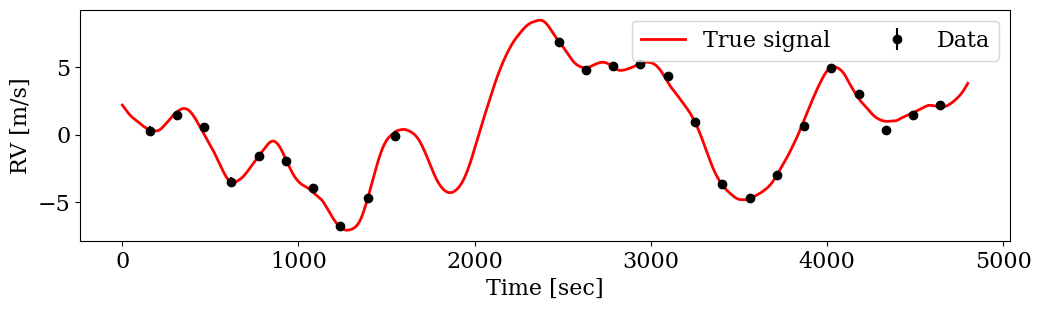

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
ax.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data')

ax.legend(ncol=2)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

In [32]:
def sample_data(N, yerr=0.3):
    return generate_data(N, qsKernel, yerr=yerr)

In [33]:
t_test = jnp.linspace(t.min(), t.max(), 1000)

# Integrated version tests

In [34]:
from smolgp.helpers import Phibar_from_VanLoan

## Augmented matrices

In [36]:
F_aug = ikernel.design_matrix()
L_aug = ikernel.noise_effect_matrix()
A_aug = lambda dt: ikernel.transition_matrix(0, dt)
Q_aug = lambda dt: ikernel.process_noise(0, dt)
Reset_matrix = ikernel.reset_matrix
print(ikernel.dimension, ':', L_aug.shape, F_aug.shape, A_aug(3).shape, Q_aug(3).shape, Reset_matrix(0).shape)

6 : (6, 1) (6, 6) (6, 6) (6, 6) (6, 6)


### New simulated dataset for testing the integrated verison

In [39]:
def generate_timeseries(tmin, tmax, texp_mean=178, texp_std=20, readout=40):
    ts = []
    texps = []
    tend_prev = tmin - readout
    while tend_prev < tmax:
        texp = np.random.normal(loc=texp_mean, scale=texp_std)
        t_start = tend_prev + readout
        t = t_start + texp/2
        tend_prev = t_start + texp
        ts.append(t)
        texps.append(texp)
    return jnp.array(ts), jnp.array(texps)

def make_exposure(tmid, texp):
    t_in_exp = jnp.linspace(tmid-texp/2, tmid+texp/2, 100)
    return jnp.mean(f(t_in_exp))

In [40]:
# tmin = t.min()
# tmax = t.max()
tmin = 0.0
tmax = 3600.0
print(tmin, tmax)

## Remake true GP
t, f = get_true_gp(tmin-300, tmax+300, 's', dt=1)
print(len(t))

0.0 3600.0
4200


In [41]:
### Change Ninst here
Ninst = 1

#### Simulated dataset
np.random.seed(231)
if Ninst==1:
    yerr = 0.3 # m/s
    texp = 180. # sec
    readout = 0 # 40 # sec
    cadence = texp + readout
    t_train = jnp.arange(tmin+texp, tmax-texp, cadence)
    N = len(t_train)
    texp_train = jnp.full(N, texp)  # constant exposure time for all observations
    yerr_train = jnp.full(N, yerr)  # constant uncertainty for all observations
    instids = jnp.zeros(N, dtype=int)
elif Ninst==2:
    ### TWO INSTRUMENTS
    texp1=55.; yerr1=0.3; rout1=20.
    texp2=600; yerr2=0.3; rout2=40.
    cadence1 = texp1 + rout1; cadence2 = texp2 + rout2
    times1 = jnp.arange(tmin+texp1, tmax-texp1, cadence1)  # uniformly sample N points
    times2 = jnp.arange(tmin+texp2, tmax-texp2, cadence2)  # uniformly sample N points

    ## EXPRES-like variable texp
    times2, texp2_train = generate_timeseries(tmin, tmax, texp_mean=180, texp_std=30, readout=40)

    ## Random subsample and generate y_train
    N1 = len(times1); N2 = len(times2);
    N1 = int(0.6*N1); N2 = int(0.8*N2)
    times1 = np.random.choice(times1, N1, replace=False)
    texp1_train = jnp.full_like(times1, texp1)
    # times2 = np.random.choice(times2, N2, replace=False)
    # texp2_train = jnp.full_like(times2, texp2)

    t_train = jnp.hstack([times1, times2])
    instids = jnp.hstack([jnp.zeros(N1, dtype=int), jnp.ones(N2, dtype=int)]) # which instrument recorded each obs
    texp_train = jnp.hstack([texp1_train, texp2_train]) # exposure time for each obs
    yerr_train = jnp.hstack([jnp.full(N1, yerr1), jnp.full(N2, yerr2)]) # uncertainty for each obs
    sortidx = jnp.argsort(t_train)
    t_train    = t_train[sortidx]
    instids    = instids[sortidx]
    texp_train = texp_train[sortidx]
    yerr_train = yerr_train[sortidx]

elif Ninst==3:
    texp1=12.; yerr1=0.3; rout1=40.
    texp2=55;  yerr2=0.3; rout2=28.
    cadence1 = texp1 + rout1; cadence2 = texp2 + rout2
    times1 = jnp.arange(tmin+texp1, tmax-texp1, cadence1)  # uniformly sample N points
    times2 = jnp.arange(tmin+texp2, tmax-texp2, cadence2)  # uniformly sample N points
    ## Random subsample and generate y_train
    N1 = len(times1); N2 = len(times2);
    N1 = int(0.6*N1); N2 = int(0.8*N2)
    times1 = np.random.choice(times1, N1, replace=False)
    texp1_train = jnp.full_like(times1, texp1)
    times2 = np.random.choice(times2, N2, replace=False)
    texp2_train = jnp.full_like(times2, texp2)

    ## EXPRES-like variable texp
    yerr3 = 0.3; rout3=40
    times3, texp3_train = generate_timeseries(tmin, tmax, texp_mean=180, texp_std=30, readout=rout3)
    N3 = len(times3)

    t_train = jnp.hstack([times1, times2, times3])
    instids = jnp.hstack([jnp.zeros(N1, dtype=int), jnp.ones(N2, dtype=int), jnp.full(N3, 2)]) # which instrument recorded each obs
    texp_train = jnp.hstack([texp1_train, texp2_train, texp3_train]) # exposure time for each obs
    yerr_train = jnp.hstack([jnp.full(N1, yerr1), jnp.full(N2, yerr2), jnp.full(N3, yerr3)]) # uncertainty for each obs
    sortidx = jnp.argsort(t_train)
    t_train    = t_train[sortidx]
    instids    = instids[sortidx]
    texp_train = texp_train[sortidx]
    yerr_train = yerr_train[sortidx]    

else:
    raise NotImplementedError("Only Ninst=1 or 2 simulated datasets implemented")

###### Generate synthetic measurements
y_inst = f(t_train)
y_true = jnp.array([make_exposure(t_train[n], texp_train[n]) for n in range(len(t_train))])
y_train = y_true + yerr * jax.random.normal(key, shape=(len(t_train),))
N = len(t_train)
R = jnp.square(yerr_train)

In [42]:
## True process
t_true = jnp.linspace(t.min(), t.max(), 1000)
y_true = f(t_true)

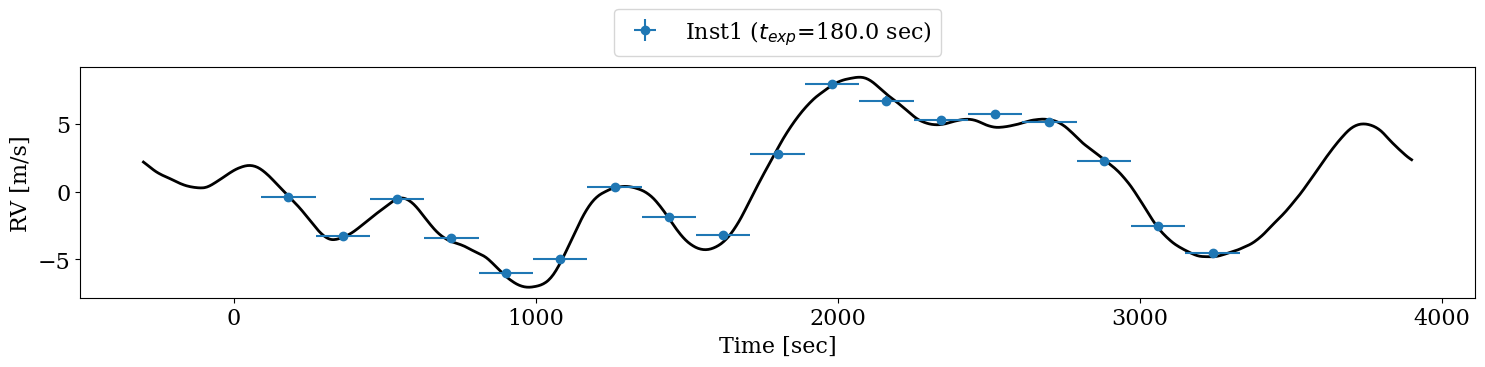

In [43]:
fig, ax = plt.subplots(1,1,figsize=(18,3))

ax.plot(t_true, y_true, #label='True signal', 
        color='k', lw=2)
# ax.errorbar(tobs.value, y_inst,  yerr=yerr, fmt='o', color='grey')
# ax.errorbar(tobs.value, y_train, xerr=texp/60/2, yerr=yerr, fmt='o', color='k', label=r'$t_{exp}$=' + f'{texp} sec')
for instid in range(Ninst):
    inst = (instids==instid)
    ax.errorbar(t_train[inst], y_train[inst], xerr=texp_train[inst]/2, yerr=yerr,
                 fmt='o', label=f'Inst{instid+1} ($t_{{exp}}$={np.median(texp_train[inst]):.1f} sec)')

ax.legend(ncol=3, bbox_to_anchor=[0.5,1], loc='lower center')
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

In [44]:
tmid = t_train # exposure midpoints

## Construct interleaved time array for integrated Kalman/RTS
ts = tmid - texp_train/2  # Exposure start times
te = tmid + texp_train/2  # Exposure end times
obsid = jnp.arange(len(tmid)).repeat(2)  # which observation does each time belong to

# Interleave start and end times into one array (fastest)
# https://stackoverflow.com/questions/5347065/interleaving-two-numpy-arrays-efficiently
t_states = jnp.empty((ts.size + te.size,), dtype=tmid.dtype)
t_states = t_states.at[0::2].set(ts)  # evens are start times
t_states = t_states.at[1::2].set(te)  # odds are end times
# Have to re-sort because exposures can overlap
sortidx  = jnp.argsort(t_states)
t_states = t_states[sortidx]
obsid    = obsid[sortidx] 
stateids = jnp.tile(jnp.array([0,1]), len(tmid))[sortidx] # 0 for t_s, 1 for t_e

In [45]:
print('k   t[s]    obs  inst  state')
print('----------------------------')
for k in range(len(t_states)):
    print(f'{k:<2d}  {t_states[k]:<7.1f}  {obsid[k]:<2}   {instids[obsid[k]]}   {stateids[k]}')
    if k>8:
        break

k   t[s]    obs  inst  state
----------------------------
0   90.0     0    0   0
1   270.0    0    0   1
2   270.0    1    0   0
3   450.0    1    0   1
4   450.0    2    0   0
5   630.0    2    0   1
6   630.0    3    0   0
7   810.0    3    0   1
8   810.0    4    0   0
9   990.0    4    0   1


## Run integrated solver

In [48]:
igp_ss = smolgp.GaussianProcess(kernel=ikernel, X=(t_train, texp_train, instids), diag=R,
                                # solver=smolgp.solvers.ParallelIntegratedStateSpaceSolver
                                )

In [49]:
# a,b,c,d, v,S = igp_ss.solver.Kalman(y_train, return_v_S=True)

## Likelihood

In [50]:
llh_ss = igp_ss.log_probability(y_train)
llh_ss

Array(-48.68500651, dtype=float64)

## Condition

In [52]:
## smolgp
llh, condGP_ss = igp_ss.condition(y_train)
llh

Array(-48.68500651, dtype=float64)

In [54]:
## Unpack conditioned states
m_predicted_int = condGP_ss.states.predicted_mean
m_filtered_int  = condGP_ss.states.filtered_mean
m_smoothed_int  = condGP_ss.states.smoothed_mean
P_predicted_int = condGP_ss.states.predicted_cov
P_filtered_int  = condGP_ss.states.filtered_cov
P_smoothed_int  = condGP_ss.states.smoothed_cov
print(m_predicted_int.shape, m_filtered_int.shape, m_smoothed_int.shape)
print(P_predicted_int.shape,P_filtered_int.shape, P_smoothed_int.shape)

(36, 6) (36, 6) (36, 6)
(36, 6, 6) (36, 6, 6) (36, 6, 6)


In [55]:
# which = stateids>=0 # stateids==1
# # plt.plot(t_states[which], m_predicted_int[:,0][which], 'o-')
# # plt.plot(t_states[which], m_filtered_int[:,0][which], 'o-')
# # plt.plot(t_states[which], m_smoothed_int[:,0][which], 'o-')

# starts = stateids==0
# ends   = stateids==1
# plt.plot(t_states[starts], m_filtered_int[:,0][starts], 'o-')
# plt.plot(t_states[ends],  m_filtered_int[:,0][ends]+.1, 'o-')

# # plt.plot(t_states[starts], m_smoothed_int[:,0][starts], 'o')
# # plt.plot(t_states[ends],  m_smoothed_int[:,0][ends]+.1, 'o')

In [57]:
y_ss = condGP_ss.loc
yvar_ss = condGP_ss.variance
yerr_ss = jnp.sqrt(yvar_ss)

## Predict

In [58]:
## Test array
# t_test = jnp.linspace(tmin-2000, tmax+2000, 1000)
t_test = jnp.linspace(tmin-300, tmax+300, 1000)

In [59]:
######## test times      0-exposure            instid=0
X_test = (t_test, jnp.zeros_like(t_test), jnp.zeros_like(t_test).astype(int))

In [60]:
## SSM predict
mu_ss, var_ss = condGP_ss.predict(X_test, return_var=True)
std_ss = jnp.sqrt(var_ss)

In [61]:
# t_states, conditioned_states, _ = condGP_ss.states()
# (m_predicted, P_predicted), \
# (m_filtered, P_filtered), \
# (m_smoothed, P_smoothed) = conditioned_states
# t_states

## Big plot

In [62]:
in_exposure = jnp.zeros_like(t_test, dtype=bool)
for t1, t2 in zip(t_states[0::2], t_states[1::2]):
    in_exposure = in_exposure | ((t_test >= t1) & (t_test <= t2))

tstart, tend = (t_train - texp_train/2), (t_train + texp_train/2)

In [63]:
mpl.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
mpl.rc("text", usetex=True)
mpl.rcParams["axes.formatter.useoffset"] = False

plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markeredgewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.linewidth'] = 2

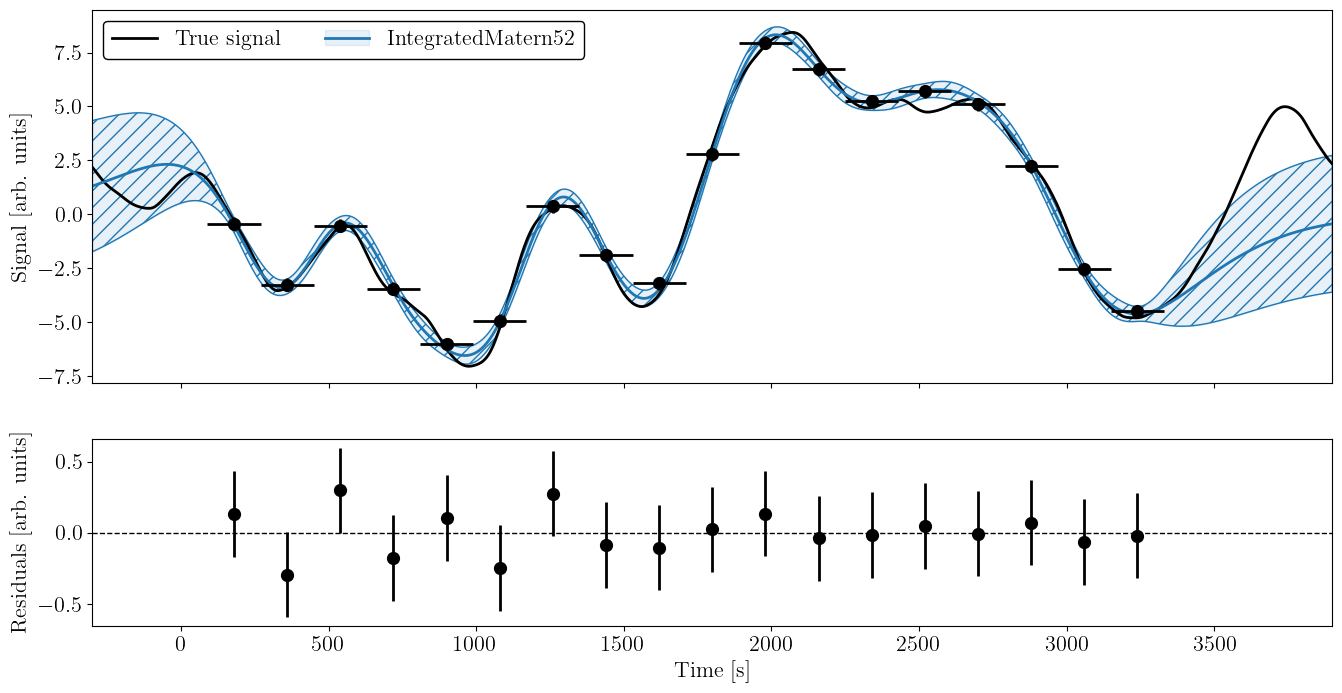

In [78]:
fig, (ax, rax) = plt.subplots(2,1, figsize=(16, 8), sharex=True, 
                                    gridspec_kw={'height_ratios':[2,1]})

css = 'C0'
datcolor = 'k'
epscolor = 'dimgrey'
s = 7

lines = []
labels = []
l, = ax.plot(t_true, y_true, ls='-', color='k', lw=2)
lines.append(l)
labels.append('True signal')

#### Plot the data points
for instid in range(Ninst):
    inst = (instids==instid)
    if Ninst>1:
        eq = '-' if instid<Ninst-1 else r'$\sim$'
        label=f'Inst{instid+1} ($t_\\textrm{{exp}}${eq}{np.median(texp_train[inst]):.0f} s)'
    else:
        label=None
    l2 = ax.errorbar(t_train[inst], y_train[inst], xerr=texp_train[inst]/2, yerr=yerr, 
                     color=datcolor, fmt='o', zorder=100)
    if label:
        lines.append(l2)
        labels.append(label)

### State space version
l, = ax.plot(t_test, mu_ss, color=css, ls='-', zorder=2)
h1 = ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, zorder=1, color=css, alpha=0.1)
h2 = ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, zorder=1, hatch="//", facecolor='none', edgecolor=css, alpha=1)
lines.append((l, h1))
labels.append(ikernel.name)

### Residuals
res_ss = y_train - condGP_ss.loc
rax.axhline(0, color='k', ls='--', lw=1)
rax.errorbar(t_train, res_ss, yerr=yerr, fmt='o', color=datcolor)
rax.set(ylabel='Residuals [arb. units]');

#### Formatting
loc = 'upper left' if Ninst>1 else 'lower center'
bbox_to_anchor = [0,1] if Ninst>1 else [0.5,1]
ax.legend(lines, labels, ncol=2, framealpha=1, edgecolor='k', 
          loc='upper left'
        #   loc=loc, bbox_to_anchor=bbox_to_anchor
            # facecolor='#232323' 
            )
if Ninst>1:
    ax.set_ylim(f(t).min()-.5, f(t).max()+2.5)
ax.set(ylabel='Signal [arb. units]', xlim=[t_test.min(), t_test.max()]);
rax.set(xlabel=f'Time [s]');
# plt.savefig(f'/Users/rrubenzahl/Desktop/figures/ss_vs_gp_integrated_Ninst{Ninst}.png', dpi=300, bbox_inches='tight')

# Inspect individual states

In [53]:
obsid   = condGP_ss.states.obsid
instid  = condGP_ss.states.instid
stateid = condGP_ss.states.stateid
t_states = condGP_ss.states.t_states

In [54]:
for k in range(len(t_states)-1):
    if stateid[k] == 0:
        if stateid[k+1]==0:
            print('start to start')
            print(k)

In [55]:
k = 58

Delta = t_states[k+1] - t_states[k]
Reset = condGP_ss.kernel.reset_matrix(instid[obsid[k]])
A_k = condGP_ss.kernel.transition_matrix(0, Delta)

## Future states
m_hat_next  = condGP_ss.states.smoothed_mean[k+1]
P_hat_next  = condGP_ss.states.smoothed_cov[k+1]
m_pred_next = condGP_ss.states.predicted_mean[k+1]
P_pred_next = condGP_ss.states.predicted_cov[k+1]
m_filt_next = condGP_ss.states.filtered_mean[k+1]
P_filt_next = condGP_ss.states.filtered_cov[k+1]

## Current state
m_filt = condGP_ss.states.filtered_mean[k]
P_filt = condGP_ss.states.filtered_cov[k]
m_pred = condGP_ss.states.predicted_mean[k]
P_pred = condGP_ss.states.predicted_cov[k]
m_smooth = condGP_ss.states.smoothed_mean[k]
P_smooth = condGP_ss.states.smoothed_cov[k]

print(['start', 'end'][stateid[k]], '<--', ['start', 'end'][stateid[k+1]])
print('Answer:')
print(m_smooth)

end <-- end
Answer:
[ 1.50204318e-01 -1.24552944e-02  6.92309404e+01  5.14535935e-01]


In [ ]:
## Testing 1-step RTS version for smoothing a start
AR = A_k @ Reset
P_pred_next_inv = jnp.linalg.inv(P_pred_next)
G_k = P_pred @ AR.T @ P_pred_next_inv
m_hat_k = m_pred + G_k @ (m_hat_next - m_pred_next)
m_hat_k

Array([-4.87641021e-01,  1.83827980e-02, -8.01436480e+01,  8.25953650e-02,
       -1.65749525e+01,  1.91569785e-01], dtype=float64)

In [57]:
jnp.isclose(m_hat_k - m_smooth, 0)

Array([ True,  True,  True,  True,  True,  True], dtype=bool)

# Inspect individual state transitions 

In [49]:
# ## Inspect transition matrix between each state transition
# A = igp_ss.kernel.transition_matrix

# for k in range(1,len(t_states)):
#     dt = t_states[k]-t_states[k-1]
#     print('State', k-1, '->', k, f': {dt:.2f} sec' )
#     print(f'Obs {obsid[k-1]} {["start","end"][stateids[k-1]]} -> Obs {obsid[k]} {["start","end"][stateids[k]]}')
#     print(A(0,dt))
#     print()

In [50]:
k = 56

print('State', k, '->', k+1)
print(f'Obs {obsid[k]} {["start","end"][stateids[k]]} -> Obs {obsid[k+1]} {["start","end"][stateids[k+1]]}')
dt = t_states[k+1]-t_states[k]
print('dt =', dt)

A = igp_ss.kernel.transition_matrix
P_pred_next = P_predicted_int[k+1]
P_k = P_filtered_int[k]
A_k = A(0, dt)

A_k

State 56 -> 57
Obs 27 end -> Obs 29 start
dt = 28.0


Array([[ 8.57998227e-01,  2.56990266e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.77205486e-03,  7.92319194e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.66534358e+01,  3.73443191e+02,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.42001773e-01,  2.56990266e+01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.66534358e+01,  3.73443191e+02,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.42001773e-01,  2.56990266e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],      dtype=float64)

In [51]:
def check_P(k):
    print('Predicted Covariance eigvals>0:')
    print('  ', jnp.linalg.eigvals(P_predicted_int[k]) > 0)
    print('Filtered Covariance eigvals>0:')
    print('  ', jnp.linalg.eigvals(P_filtered_int[k]) > 0)
    print('Smoothed Covariance eigvals>0:')
    print('  ', jnp.linalg.eigvals(P_smoothed_int[k]) > 0)
    print()

# print('State 0')
# check_P(0)
for k in range(1, len(t_states)):
    if stateids[k]<2:
        print('State', k-1, '->', k)
        print(['start','end'][stateids[k-1]], '->', ['start','end'][stateids[k]])
        dt = t_states[k]-t_states[k-1] if k>0 else 0.0
        print('dt =', dt)
        check_P(k)

State 0 -> 1
start -> start
dt = 27.5
Predicted Covariance eigvals>0:
   [ True  True  True  True  True  True]
Filtered Covariance eigvals>0:
   [ True  True  True  True False False]
Smoothed Covariance eigvals>0:
   [ True  True  True  True  True  True]

State 1 -> 2
start -> end
dt = 55.0
Predicted Covariance eigvals>0:
   [ True  True  True  True  True  True]
Filtered Covariance eigvals>0:
   [ True  True  True  True  True  True]
Smoothed Covariance eigvals>0:
   [ True  True  True  True  True  True]

State 2 -> 3
end -> start
dt = 28.0
Predicted Covariance eigvals>0:
   [ True  True  True  True  True  True]
Filtered Covariance eigvals>0:
   [ True  True  True  True False False]
Smoothed Covariance eigvals>0:
   [ True  True  True  True  True  True]

State 3 -> 4
start -> end
dt = 55.0
Predicted Covariance eigvals>0:
   [ True  True  True  True  True  True]
Filtered Covariance eigvals>0:
   [ True  True  True  True  True  True]
Smoothed Covariance eigvals>0:
   [ True  True  True  T

In [ ]:
jnp.linalg.eigvals(P_pred_next) > 0

Array([ True,  True,  True,  True,  True,  True], dtype=bool)

In [ ]:
jnp.linalg.eigvals(P_k)>0

Array([ True,  True,  True,  True, False, False], dtype=bool)

In [ ]:
badthing = (P_k @ A_k.T).T
jnp.all(jnp.linalg.eigvals(badthing) > 0)

Array(False, dtype=bool)

In [ ]:
jnp.linalg.solve(P_pred_next.T, (P_k @ A_k.T).T).T

Array([[ nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  inf, -inf],
       [ nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan, -inf,  inf],
       [ nan,  nan,  nan,  nan,  nan,  nan]], dtype=float64)

In [ ]:
igp_ss.kernel.transition_matrix(0, 0)

Array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [-0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [-0.,  0.,  0.,  0.,  0.,  1.]], dtype=float64)

In [ ]:
igp_ss.kernel.integrated_transition_matrix(0, 0)

Array([[ 0.,  0.],
       [-0.,  0.]], dtype=float64)

# TODO: test predict with arbitrary exposure time